In [1]:
!git clone https://github.com/zhn66776/Tidal_try.git

Cloning into 'Tidal_try'...
remote: Enumerating objects: 1258, done.
remote: Counting objects: 100% (127/127), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 1258 (delta 41), reused 56 (delta 10), pack-reused 1131 (from 2)
Receiving objects: 100% (1258/1258), 123.26 MiB | 14.11 MiB/s, done.
Resolving deltas: 100% (568/568), done.
Updating files: 100% (370/370), done.


In [2]:
cd Tidal_try

/content/Tidal_try


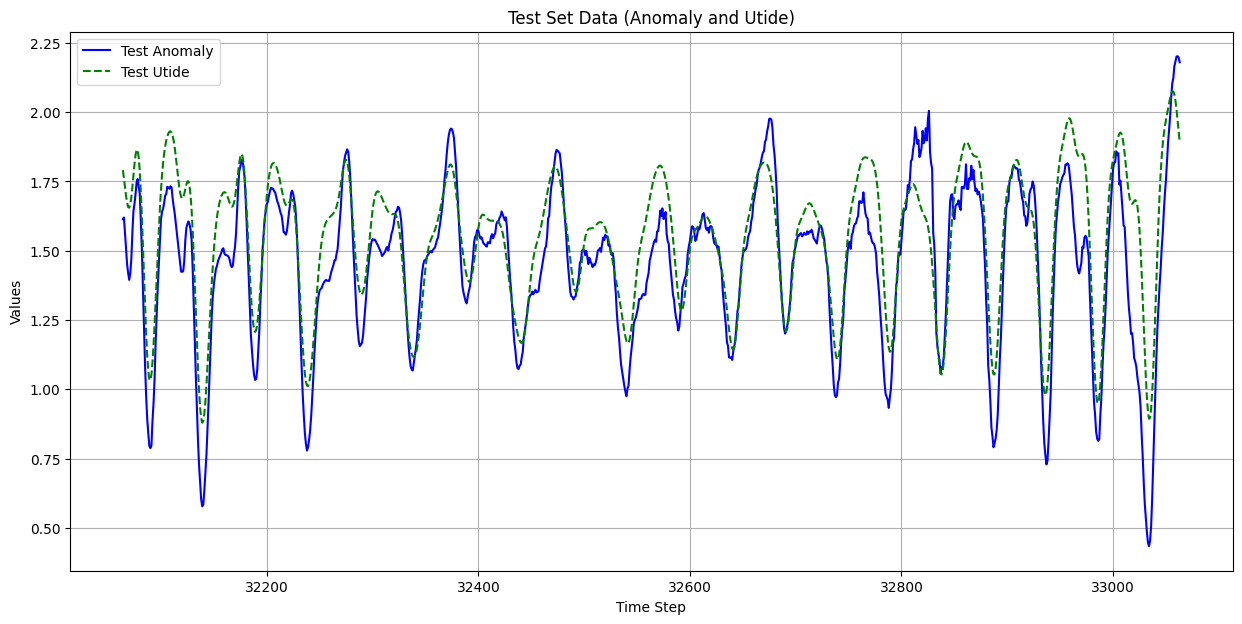

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
input_file = "dataProcessed/BOU2019_HA.csv"
df = pd.read_csv(input_file, delimiter=',')

total_train_points = 31964
look_back_points = 100
show_points = 1000
total_test_points = 2976
start_index = 0


test_start_index = start_index + total_train_points + look_back_points
test_end_index = test_start_index + show_points

test_anomaly = df['anomaly'][test_start_index:test_end_index].values
test_utide = df['tide_h'][test_start_index:test_end_index].values

plt.figure(figsize=(15, 7))
plt.plot(range(test_start_index, test_end_index), test_anomaly, label='Test Anomaly', color='blue')
plt.plot(range(test_start_index, test_end_index), test_utide, label='Test Utide', color='green', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Values')
plt.title('Test Set Data (Anomaly and Utide)')
plt.legend()
plt.grid(True)
plt.show()

Training BiLSTM_2feat multi-output (utide_factor=1, future_steps=27)...
Epoch 1/80
112/112 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 0.1516 - val_loss: 0.0354 - learning_rate: 0.0010
Epoch 2/80
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0357 - val_loss: 0.0182 - learning_rate: 0.0010
Epoch 3/80
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0206 - val_loss: 0.0116 - learning_rate: 0.0010
Epoch 4/80
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0141 - val_loss: 0.0082 - learning_rate: 0.0010
Epoch 5/80
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0105 - val_loss: 0.0062 - learning_rate: 0.0010
Epoch 6/80
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0082 - val_loss: 0.0047 - learning_rate: 0.0010
Epoch 7/80
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0067 - val_loss: 0.0039 - learning_rate: 0.0010
Epoch 8/80
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0057 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 9/80
112/112 ━━━━━━━━━━━━━━━━━━━━ 

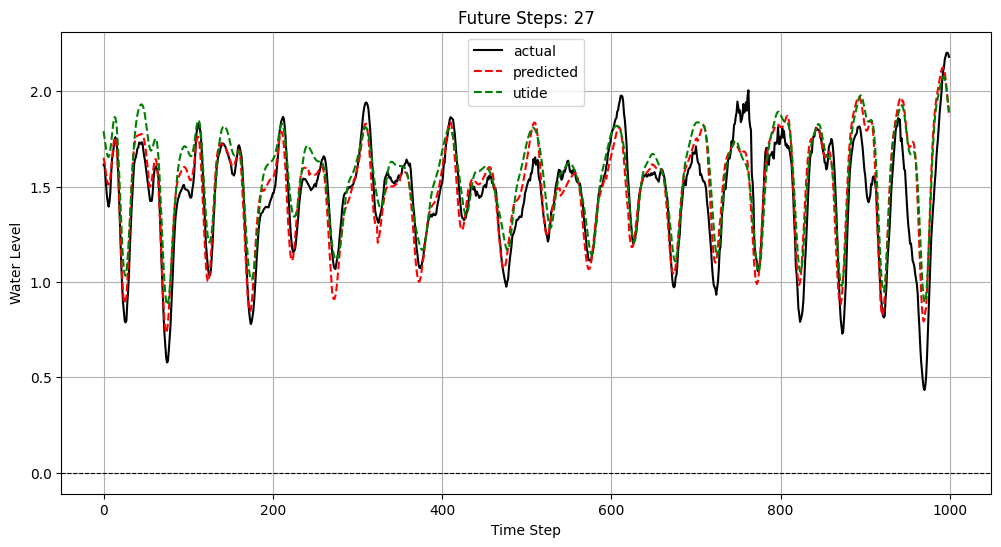

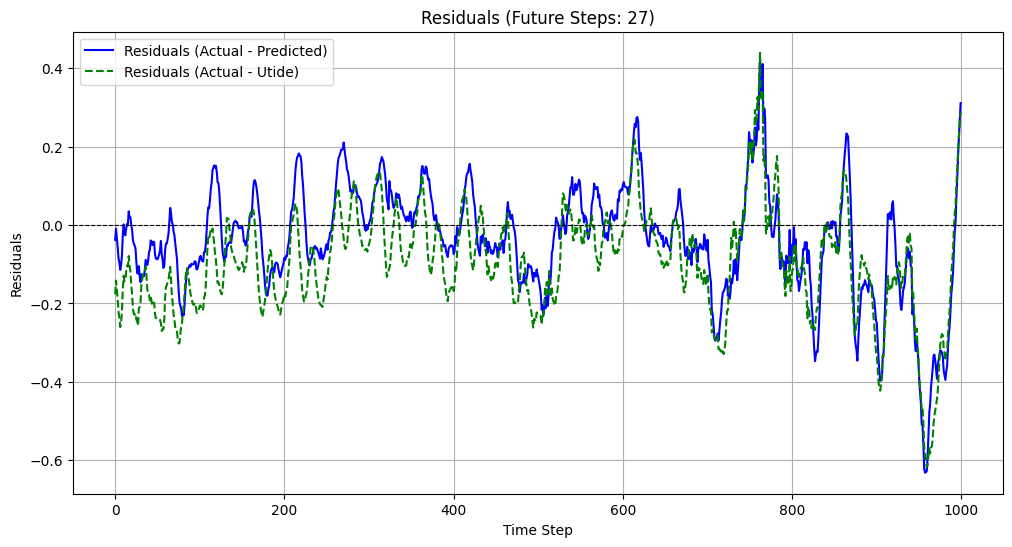

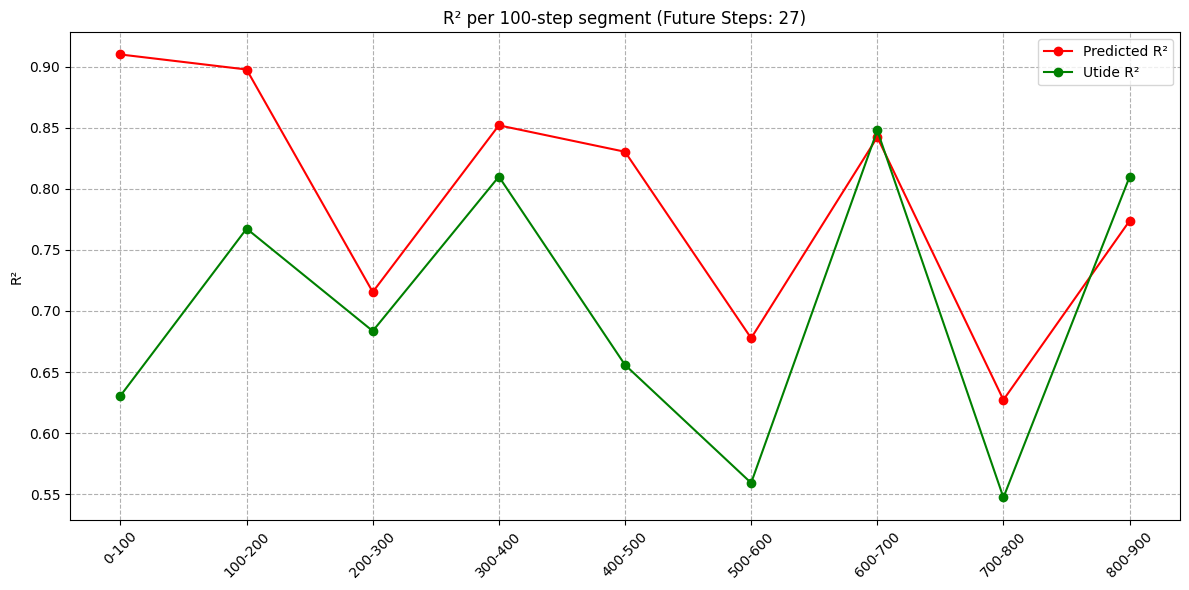

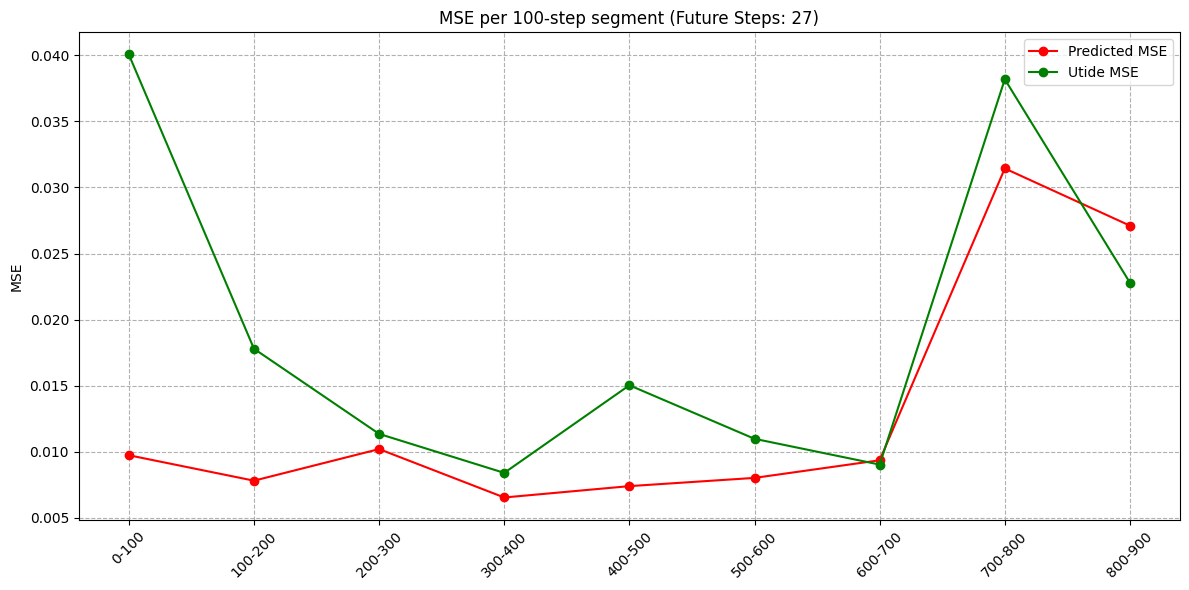

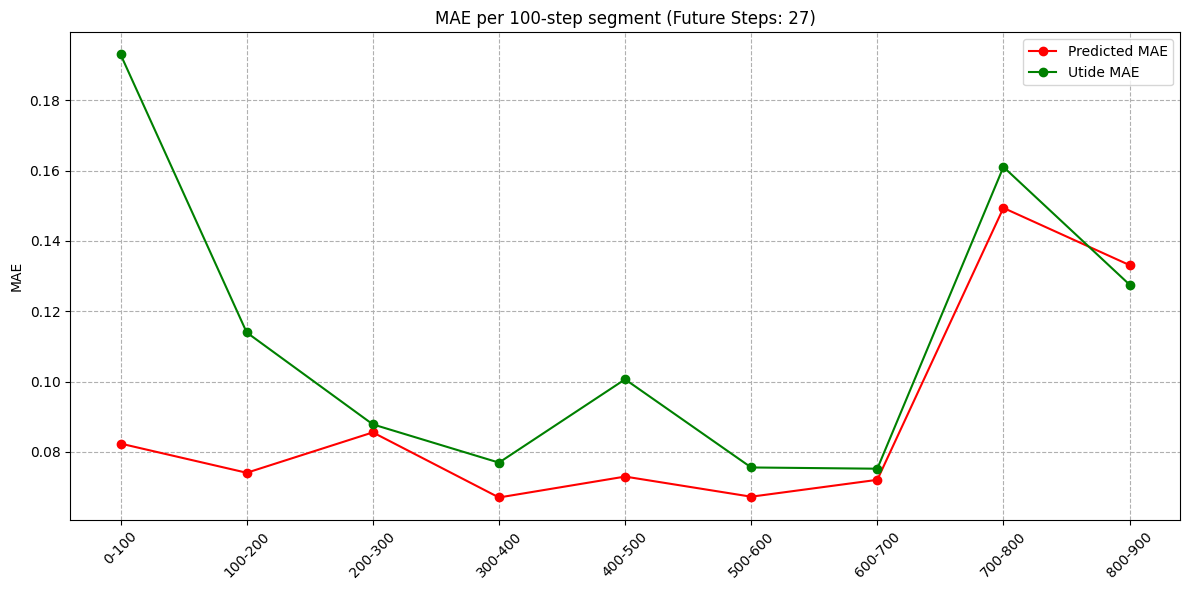

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, LSTM, Dropout, Bidirectional, Input
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
random.seed(3407)
np.random.seed(3407)
tf.random.set_seed(3407)
input_file = "dataProcessed/BOU2019_HA.csv"
df = pd.read_csv(input_file, delimiter=',')

total_train_points = 31964
look_back_points = 100
total_test_points = 2976
start_index = 0
utide_factor = 1
future_steps_list = [27]

total_required = total_train_points + look_back_points + total_test_points

df_sampled = df.iloc[start_index:start_index + total_required].reset_index(drop=True)
anomaly = df_sampled['anomaly'].values.reshape(-1, 1)
utide_original = df_sampled['tide_h'].values.reshape(-1, 1)
utide_adjusted = utide_original * utide_factor

scaler_anomaly_train = MinMaxScaler(feature_range=(0, 1))
scaler_utide_train = MinMaxScaler(feature_range=(0, 1))
scaler_anomaly_train.fit(anomaly)
scaler_utide_train.fit(utide_adjusted)

anomaly_scaled = scaler_anomaly_train.transform(anomaly)
utide_scaled = scaler_utide_train.transform(utide_adjusted)
dataset_scaled_multi = np.hstack((anomaly_scaled, utide_scaled))

train_multi = dataset_scaled_multi[:total_train_points]
test_multi = dataset_scaled_multi[total_train_points: total_train_points + total_test_points + look_back_points]

def create_dataset_multi_multioutput(dataset, look_back, future_steps):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - future_steps + 1):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        future_values = [dataset[i + look_back + j, 0] for j in range(future_steps)]
        dataY.append(future_values)
    return np.array(dataX), np.array(dataY)

def inverse_anomaly_array(arr_scaled):
    arr_scaled = arr_scaled.reshape(-1, 1)
    return scaler_anomaly_train.inverse_transform(arr_scaled).flatten()

def inverse_utide_array_factor(arr_scaled):
    arr_scaled = arr_scaled.reshape(-1, 1)
    utide_factor_domain = scaler_utide_train.inverse_transform(arr_scaled).flatten()
    return utide_factor_domain / utide_factor


def build_bilstm_multi(input_shape, future_steps):
    input_layer = Input(shape=input_shape)
    x = Bidirectional(LSTM(100, return_sequences=True, kernel_regularizer=l2(0.0001)))(input_layer)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(100, return_sequences=True, kernel_regularizer=l2(0.0001)))(x)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(100, kernel_regularizer=l2(0.0001)))(x)
    x = Dropout(0.3)(x)
    output_layer = Dense(future_steps)(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

results_to_save = []

for future_steps in future_steps_list:
    trainX_multi, trainY_multi = create_dataset_multi_multioutput(train_multi, look_back_points, future_steps)
    testX_multi, testY_multi = create_dataset_multi_multioutput(test_multi, look_back_points, future_steps)
    trainX, valX, trainY, valY = train_test_split(trainX_multi, trainY_multi, test_size=0.1, random_state=3407)


    model = build_bilstm_multi((look_back_points, 2), future_steps)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, min_lr=1e-6)
    epochs = 80
    batch_size = 256

    print(f"Training BiLSTM_2feat multi-output (utide_factor={utide_factor}, future_steps={future_steps})...")
    model.fit(trainX, trainY, validation_data=(valX, valY), epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[reduce_lr])
    print("Training completed.\n")

    # rolling
    current_input = test_multi[:look_back_points].copy()
    predictions_scaled = []
    actual_scaled = []
    utide_scaled_arr = []

    predicted_points = 0
    while predicted_points < total_test_points:
        input_sequence = current_input.reshape(1, look_back_points, 2)
        future_pred_scaled = model.predict(input_sequence, verbose=0)[0]

        for step_i in range(future_steps):
            if predicted_points >= total_test_points:
                break
            predictions_scaled.append(future_pred_scaled[step_i])
            actual_scaled_val = test_multi[look_back_points + predicted_points, 0]
            utide_scaled_val = test_multi[look_back_points + predicted_points, 1]
            actual_scaled.append(actual_scaled_val)
            utide_scaled_arr.append(utide_scaled_val)
            current_input = np.roll(current_input, -1, axis=0)
            current_input[-1, 0] = future_pred_scaled[step_i]
            if predicted_points + 1 < total_test_points:
                current_input[-1, 1] = test_multi[look_back_points + predicted_points + 1, 1]
            else:
                current_input[-1, 1] = test_multi[look_back_points + predicted_points, 1]

            predicted_points += 1

    predicted_anomaly = inverse_anomaly_array(np.array(predictions_scaled))
    actual_anomaly = inverse_anomaly_array(np.array(actual_scaled))
    actual_utide = inverse_utide_array_factor(np.array(utide_scaled_arr))
    residuals_predicted = actual_anomaly[:1000] - predicted_anomaly[:1000]
    residuals_utide = actual_anomaly[:1000] - actual_utide[:1000]

    plt.figure(figsize=(12, 6))
    plt.plot(actual_anomaly[:1000], label='actual', color='black')
    plt.plot(predicted_anomaly[:1000], label='predicted', color='red', linestyle='--')
    plt.plot(actual_utide[:1000], label='utide', color='green', linestyle='--')
    plt.title(f'Future Steps: {future_steps}')
    plt.xlabel('Time Step')
    plt.ylabel('Water Level')
    plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
    plt.legend()
    plt.grid(True)
    plt.show()

    #residual
    plt.figure(figsize=(12, 6))
    plt.plot(residuals_predicted, label='Residuals (Actual - Predicted)', color='blue')
    plt.plot(residuals_utide, label='Residuals (Actual - Utide)', color='green', linestyle='--')
    plt.title(f'Residuals (Future Steps: {future_steps})')
    plt.xlabel('Time Step')
    plt.ylabel('Residuals')
    plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
    plt.legend()
    plt.grid(True)
    plt.show()


    num_segments = 9
    segment_length = 100
    segment_labels = []
    r2_pred_list, mse_pred_list, mae_pred_list = [], [], []
    r2_utide_list, mse_utide_list, mae_utide_list = [], [], []

    for seg_i in range(num_segments):
        start = seg_i * segment_length
        end = start + segment_length

        seg_actual = actual_anomaly[start:end]
        seg_pred = predicted_anomaly[start:end]
        seg_utide = actual_utide[start:end]

        r2_pred = r2_score(seg_actual, seg_pred)
        mse_pred = mean_squared_error(seg_actual, seg_pred)
        mae_pred = mean_absolute_error(seg_actual, seg_pred)

        r2_utide = r2_score(seg_actual, seg_utide)
        mse_utide = mean_squared_error(seg_actual, seg_utide)
        mae_utide = mean_absolute_error(seg_actual, seg_utide)

        r2_pred_list.append(r2_pred)
        mse_pred_list.append(mse_pred)
        mae_pred_list.append(mae_pred)

        r2_utide_list.append(r2_utide)
        mse_utide_list.append(mse_utide)
        mae_utide_list.append(mae_utide)

        segment_labels.append(f'{start}-{end}')

    #R²
    plt.figure(figsize=(12,6))
    x = np.arange(num_segments)
    plt.plot(x, r2_pred_list, marker='o', color='red', label='Predicted R²')
    plt.plot(x, r2_utide_list, marker='o', color='green', label='Utide R²')
    plt.title(f'R² per 100-step segment (Future Steps: {future_steps})')
    plt.xticks(x, segment_labels, rotation=45)
    plt.ylabel('R²')
    plt.grid(True, linestyle='--', linewidth=0.8)
    plt.legend()
    plt.tight_layout()
    plt.show()

    #MSE
    plt.figure(figsize=(12,6))
    plt.plot(x, mse_pred_list, marker='o', color='red', label='Predicted MSE')
    plt.plot(x, mse_utide_list, marker='o', color='green', label='Utide MSE')
    plt.title(f'MSE per 100-step segment (Future Steps: {future_steps})')
    plt.xticks(x, segment_labels, rotation=45)
    plt.ylabel('MSE')
    plt.grid(True, linestyle='--', linewidth=0.8)
    plt.legend()
    plt.tight_layout()
    plt.show()

    #MAE
    plt.figure(figsize=(12,6))
    plt.plot(x, mae_pred_list, marker='o', color='red', label='Predicted MAE')
    plt.plot(x, mae_utide_list, marker='o', color='green', label='Utide MAE')
    plt.title(f'MAE per 100-step segment (Future Steps: {future_steps})')
    plt.xticks(x, segment_labels, rotation=45)
    plt.ylabel('MAE')
    plt.grid(True, linestyle='--', linewidth=0.8)
    plt.legend()
    plt.tight_layout()
    plt.show()


    for t, pred, actual, utide in zip(range(len(predicted_anomaly)), predicted_anomaly, actual_anomaly, actual_utide):
        results_to_save.append({
            'future_steps': future_steps,
            'Time_Step': t,
            'Predicted_Values': pred,
            'Actual_Values': actual,
            'Utide_Values': utide
        })


results_df = pd.DataFrame(results_to_save)

In [ ]:

results_df = pd.DataFrame(results_to_save)
output_file = "BOUU2019_utide(111)27.csv"
results_df.to_csv(output_file, index=False)
print(f"Results saved to {output_file}")

Results saved to BOUU2019_utide(111)27.csv
